# Занятие 5
# Прикладная алгебра и численные методы
## Интерполяция: полиномы Лагранжа, сплайны и кривые Безье

In [1]:
import numpy as np
import scipy.linalg
import sympy
from sympy import S
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

## Многочлен Лагранжа
$$
f(x) = L(x) = \sum_{i=1}^n y_i 
\frac{(x - x_0)(x - x_1)...(x - x_{i-1})(x - x_{i+1})...(x - x_n)}{(x_i - x_0)(x_i - x_1)...(x_i - x_{i-1})(x_i - x_{i+1})...(x_i - x_n)}, 
\quad y_i = f(x_i), \quad i = 0, ..., n.
$$
## Пример 1
Построить параболу по трем точкам (-1, -2), (0, -1), (1, 2).

In [2]:
x = S('x')
X = (-1, 0, 1)
Y = (-2, -1, 2)
L = 0
for i in range(3):
    Li = Y[i]
    for j in range(3):
        if i != j:
            Li *= (x - X[j])/(X[i] - X[j])
    L += Li
display(L, sympy.simplify(sympy.expand(L)))  

2*x*(1/2 - x/2) + x*(x + 1) + (1 - x)*(-x - 1)

x**2 + 2*x - 1

## Пример 2 Линейная регрессия
Для данных Примера 1 построим параболу методом линейной регрессии (исключительно для тренировки и повторения, в жизни так не делают!)

Составим матрицу  из $A$ из значений $x$ и $x^2$ и матрицу $Y$, далее все как обычно - псевдообратная матрица и произведение псевдообратной к  $A$ и  $Y$:

In [3]:
X2 = [ -1, 0, 1]
A2 = np.array([[1, item, item**2] for item in X2])
Y2 = np.array([[-2], [-1], [2]])
res2 = np.matmul(np.linalg.pinv(A2), Y2)
a2, b2, c2 = [round(item, 2) for item in  res2[:, 0]]
display('A', A2,'Y', Y)
print('a =', a2, 'b =', b2, 'c =', c2)

'A'

array([[ 1, -1,  1],
       [ 1,  0,  0],
       [ 1,  1,  1]])

'Y'

(-2, -1, 2)

a = -1.0 b = 2.0 c = 1.0


Изобразим на графике точки исходных данных и полученную линию регрессии:

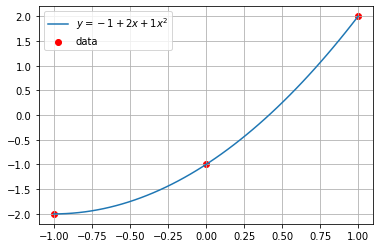

In [4]:
X_ls2 = np.linspace(X2[0], X2[-1])
plt.plot(X_ls2, a2 + b2*X_ls2 + c2*X_ls2**2, label='$y = {a} + {b}x + {c}x^2$'.format(a=round(a2), 
                                                                                      b=round(b2), c=round(c2)))
plt.scatter(X2, Y2, color='red', label='data')
plt.grid()
plt.legend()

## Пример 3 Линейная регрессия
Для данных точек построим наилучшую в смысле среднеквадратического отклонения параболу методом линейной регрессии.
$$
\begin{matrix}
X & -3 & -1 & 0 & 1 & 3\\
Y & -4 & -0.8 & 1.6 & 2.3 & 1.5
\end{matrix}
$$

In [5]:
X3 = [ -3, -1, 0, 1, 3]
A3 = np.array([[1, item, item**2] for item in X3])
Y3 = np.array([[-4], [-0.8], [1.6], [2.3], [1.5]])
res3 = np.matmul(np.linalg.pinv(A3), Y3)
a3, b3, c3 = [round(item, 2) for item in  res3[:, 0]]
print('a =', a3, 'b =', b3, 'c =', c3)

a = 1.23 b = 0.98 c = -0.28


Построим график, отметим на нем исходные точки.

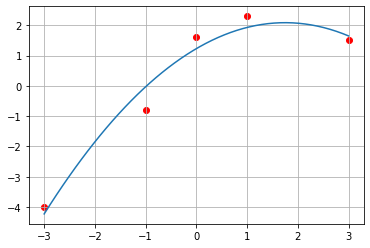

In [6]:
X_ls = np.linspace(X3[0], X3[-1])
plt.plot(X_ls, a3 + b3*X_ls + c3*X_ls**2)
plt.scatter(X3, Y3, color='red')
plt.grid()

## Пример 4
Построим полином Лагранжа для данных Примера 3:

x**4/15 - 19*x**3/240 - 11*x**2/12 + 391*x/240 + 8/5

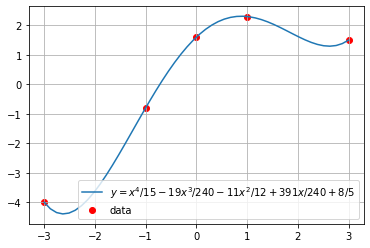

In [7]:
x = S('x')
Y3 = [-4, -S(8)/10, S(16)/10, S(23)/10, S(15)/10]
L3 = 0
n = len(X3)
for i, Li in enumerate(Y3):
    for j in range(n):
        if i != j:
            Li *= (x - X3[j])/(X3[i] - X3[j])
    L3 += Li
L3 = sympy.simplify(sympy.expand(L3))    
display(L3)
X_ls = np.linspace(X3[0], X3[-1])
Y_regr = [L3.subs(x, item) for item in X_ls]
plt.plot(X_ls, Y_regr, label=sympy.latex(sympy.Eq(S('y'), L3), mode='inline'))
plt.scatter(X3, Y3, color='red', label='data')
plt.grid()
plt.legend()

## Многочлен Лагранжа с scipy.interpolate.lagrange
## Пример 5
Построим полином Лагранжа для данных Примера 3 с помощью scipy.interpolate.lagrange

In [8]:
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [9]:
poly = lagrange(X3, Y3)
Polynomial(poly).coef

array([0.0666666666666667, -0.0791666666666667, -0.916666666666667,
       1.62916666666667, 1.60000000000000], dtype=object)

Сравним с полученными ранее коэффициентами:

In [10]:
coeffs = L3.as_coefficients_dict()
res = [round(coeffs[item], 8) for item in [x**k for k in range(len(coeffs))]]
res.reverse()
res

[0.06666667, -0.07916667, -0.91666667, 1.62916667, 1.60000000]

## Квадратичный сплайн

## Пример 7
Аппроксимировать $f(x) = x^3 - 6x^2 + 11 x - 6$ на отрезке $[0, 4]$ квадратичным сплайном с узлами 0, 2, 4.

In [11]:
def spl2(a0, a1, a2, x):
    return a0 + a1*x + a2*x**2
def dspl2(a0, a1, a2, x, x0):
    return spl2(a0, a1, a2, x).diff(x).subs(x, x0)
def f(x):
    return x**3 - 6*x**2 + 11*x - 6
def df(x, x0):
    return f(x).diff(x).subs(x, x0)
x0 = 0
x1 = 2
x2 = 4
f0, f1, f2 = [f(xi) for xi in (x0, x1, x2)]
df0 = df(x, x0)
a0, a1, a2, x = sympy.symbols('a0:3 x')
sys1 = [sympy.Eq(dspl2(a0, a1, a2, x, x0), df0), sympy.Eq(spl2(a0, a1, a2, x0), f0), sympy.Eq(spl2(a0, a1, a2, x1), f1)]
display(*sys1)

Eq(a1, 11)

Eq(a0, -6)

Eq(a0 + 2*a1 + 4*a2, 0)

In [12]:
res1 = sympy.solve(sys1)
spline1 = res1[a0] + res1[a1]*x + res1[a2]*x**2
display(res1, spline1)
df1 = spline1.diff(x).subs(x, x1)
sys2 = [sympy.Eq(dspl2(a0, a1, a2, x, x1), df1), 
                   sympy.Eq(spl2(a0, a1, a2, x1), f1), 
                   sympy.Eq(spl2(a0, a1, a2, x2), f2)]
res2 = sympy.solve(sys2)

spline2 = res2[a0] + res2[a1]*x + res2[a2]*x**2
display(*sys2, spline2)

{a0: -6, a1: 11, a2: -4}

-4*x**2 + 11*x - 6

Eq(a1 + 4*a2, -5)

Eq(a0 + 2*a1 + 4*a2, 0)

Eq(a0 + 4*a1 + 16*a2, 6)

4*x**2 - 21*x + 26

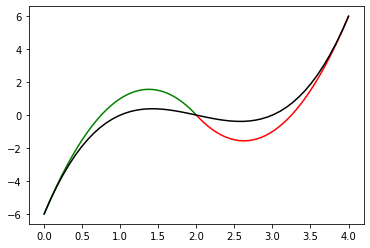

In [13]:
x0, x1, x2 = (0, 2, 4)
X_ls1 = np.linspace(x0, x1)
X_ls2 = np.linspace(x1, x2)
X_ls12 = np.linspace(x0, x2)
Y1 = [spline1.subs(x, item) for item in X_ls1] 
Y2 = [spline2.subs(x, item) for item in X_ls2]          
plt.plot(X_ls1, Y1, color='green')
plt.plot(X_ls2, Y2, color='red')
plt.plot(X_ls12, f(X_ls12), color='black')

## Кубический сплайн
$$
f_i(x) = a_ix^3 + b_ix^2 + c_ix + d,
\quad
\left\{
\begin{matrix}
f_i(x_{i - 1}) = y_{i - 1}\\
f_i(x_{i}) = y_{i}\\
f_i'(x_{i - 1}) = f'_{i - 1}(x_{i - 1})\\
f_i''(x_{i - 1}) = f''_{i - 1}(x_{i - 1})
\end{matrix}
\right.
$$
## Пример 8
Аппроксимировать $f(x) = \sin(x)$ на отрезке $\left[0, \frac{2\pi}{3}\right]$ квадратичным сплайном с узлами 
0, $\frac{\pi}{3}$, $\frac{2\pi}{3}$.

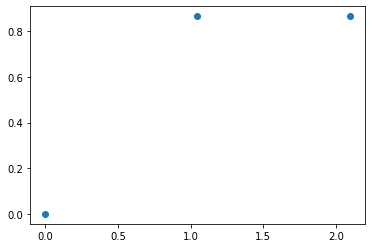

In [14]:
X = [np.pi*k/3 for k in range(3)]
Y = [np.sin(xk) for xk in X]
plt.scatter(X, Y)

Вначале определим несколько вспомогательных функций:

spl3(a0, a1, a2, a3, x) кубическая парабола с коэффициентами a0, a1, a2, a3 и аргументом x

dspl3(a1, a2, a3, x) - первая производная кубического сплайна

d2spl3(a2, a3, x) - вторая производная кубического сплайна

sys_spl(f, x, xi, xi_1, yi, yi_1, d1spl, d2spl) - система уравнений относительно коэффициентов сплайна

In [15]:
def spl3(a0, a1, a2, a3, x):
    return a0 + a1*x + a2*x**2 + a3*x**3
def dspl3(a1, a2, a3, x):
    return a1 + 2*a2*x + 3*a3*x**2
def d2spl3(a2, a3, x):
    return 2*a2 + 6*a3*x
def sys_spl(f, x, xi, xi_1, yi, yi_1, d1spl, d2spl):
    return [sympy.Eq(spl3(a0, a1, a2, a3, xi_1), yi_1),
            sympy.Eq(spl3(a0, a1, a2, a3, xi), yi),
            sympy.Eq(dspl3(a1, a2, a3, xi_1), d1spl),
            sympy.Eq(d2spl3(a2, a3, xi_1), d2spl)]

Нам понадобится $\sin(x)$ из numpy для построения графика и из sympy для получения сплайна (аналитически), поэтому опишем функцию fx(x, lib='sympy'), в которой по умолчанию $\sin(x)$ берется из из sympy, но можно изменить значение по умолчанию параметра lib на 'numpy'.

In [16]:
def fx(x, lib='sympy'):
    if lib == 'sympy':
        return sympy.sin(x)
    if lib == 'numpy':
        return np.sin(x)

Введем переменные в математическом смысле - символы a0, a1, a2, a3, x.

Обозначим xi_1 горизонтальную координату первой точки, xi - второй, yi_1 и yi - соответствующие вертикальные координаты, 
d1spl и d2spl - значения первой и второй производной на левом конце отрезка, т.е. в xi_1, они для самого левого отрезка равны производным самой функции в этой точке. 

Для построения сплайна воспользуемся решением с помощью solve соответствующей системы уравнений относительно коэффициентов сплайна.

Полученные значения коэффициентов используем для получения выражения (expression) для сплайна на левом отрезке spline3

In [17]:
a0, a1, a2, a3, x = sympy.symbols('a0:4 x')
xi_1 = X[0]
xi = X[1]
yi_1 = fx(xi_1)
yi = fx(xi)
d1spl = fx(x).diff(x).subs(x, xi_1) 
d2spl = fx(x).diff(x, 2).subs(x, xi_1)
sys3 = sys_spl(fx, x, xi, xi_1, yi, yi_1, d1spl, d2spl)
display(*sys3)
res3 = sympy.solve(sys3)
spline3 = res3[a0] + res3[a1]*x + res3[a2]*x**2 + res3[a3]*x**3
display(spline3)

Eq(a0, 0)

Eq(a0 + 1.0471975511966*a1 + 1.09662271123215*a2 + 1.14838061778888*a3, 0.866025403784439)

Eq(a1, 1)

Eq(2*a2, 0)

-0.1577631532662*x**3 + 1.0*x

Повторим те же действия со следующим отрезком, т.е. $\left[\frac{\pi}{3}, \frac{2\pi}{3}\right]$.

Отличие в том, что производные первого и второго порядков считаются не по исходной функции, а по построенному куску сплайна, т.е. считаем производные от  spline3 в точке $\frac{\pi}{3}$.

In [18]:
xi_1 = X[1]
xi = X[2]
yi_1 = fx(xi_1)
yi = fx(xi)
d1spl = spline3.diff(x).subs(x, xi_1) 
d2spl = spline3.diff(x, 2).subs(x, xi_1)
sys4 = sys_spl(fx, x, xi, xi_1, yi, yi_1, d1spl, d2spl)
display(*sys4)
res4 = sympy.solve(sys4)
spline4 = res4[a0] + res4[a1]*x + res4[a2]*x**2 + res4[a3]*x**3
display(spline4)

Eq(a0 + 1.0471975511966*a1 + 1.09662271123215*a2 + 1.14838061778888*a3, 0.866025403784439)

Eq(a0 + 2.0943951023932*a1 + 4.3864908449286*a2 + 9.18704494231105*a3, 0.866025403784439)

Eq(a1 + 2.0943951023932*a2 + 3.28986813369645*a3, 0.480980029398058)

Eq(2*a2 + 6.28318530717959*a3, -0.991255126616512)

0.0346882668161555*x**3 - 0.604603967503653*x**2 + 1.63313979421358*x - 0.221007480688529

Построим на графике исходную функцию и весь сплайн (из двух кусков)

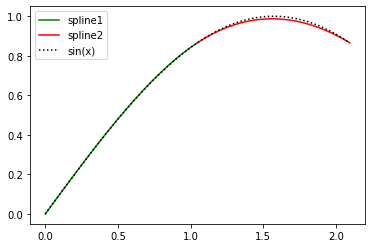

In [19]:
x0, x1, x2 = X
X_ls1 = np.linspace(x0, x1)
X_ls2 = np.linspace(x1, x2)
X_ls12 = np.linspace(x0, x2)
Y1 = [spline3.subs(x, item) for item in X_ls1] 
Y2 = [spline4.subs(x, item) for item in X_ls2]          
plt.plot(X_ls1, Y1, color='green', label='spline1')
plt.plot(X_ls2, Y2, color='red', label='spline2')
plt.plot(X_ls12, fx(X_ls12, lib='numpy'), color='black', linestyle=':', label='sin(x)')
plt.legend()

## Сплайны scipy.interpolate: interp1d, splrep, InterpolatedUnivariateSpline
https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate
#### Кубический сплайн:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline
####  interp1d
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d
####  Полиномы Бернштейна
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BPoly.html#scipy.interpolate.BPoly

Теперь будем строить сплайны средствами scipy.interpolate, вначале подключим необходимые функции:

In [28]:
from scipy.interpolate import interp1d, splrep, splev, InterpolatedUnivariateSpline, BPoly, CubicSpline

## interp1d
Параметры $x$ и  $y$ - координаты узлов сплайна, 
kind - str или int, необязательный параметр, определяющий тип сплайна, по умолчанию линейный (‘linear’), можно сделать ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’ или ‘next’. 

‘zero’, ‘slinear’, ‘quadratic’ и ‘cubic’ обозначают интерполяцию нулевого, первого, второго или третьего порядка,

‘previous’ и ‘next’ просто возвращают предыдущее или следующее значение функции

‘nearest-up’ и ‘nearest’ различаются обработкой полуцелых чисел, таких как 0.5, 1.5.

## Пример 9
Аппроксимировать $f(x) = \sin(x)$ на отрезке $\left[0, 2\pi\right]$ квадратичным сплайном с узлами 
$\frac{\pi k}{4}$, $k = 0, ..., 8$.

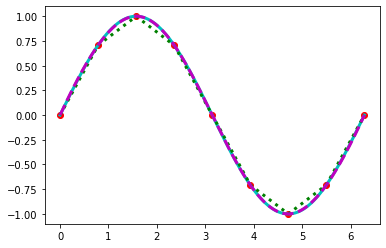

In [21]:
X = [np.pi*k/4 for k in range(9)]
Y = [np.sin(xk) for xk in X]
plt.scatter(X, Y, color='red')
spl1 = interp1d(X, Y)
spl2 = interp1d(X, Y, kind='cubic')
xs = np.linspace(X[0], X[-1], 1000)
plt.plot(xs, np.sin(xs), 'c-', xs, spl1(xs), 'g:', xs, spl2(xs), 'm--', lw=3)

## Еще один способ построения сплайна: 

splrep функция, которая возвращает представление  B-spline кривой

splev вычисляет значения B-spline или его производных

Есть еще полезные функции:

sproot находит корни кубического B-spline

splint вычисляет определенный интеграл  B-spline на отрезке

spalde вычисляет все производные B-spline

splrep, splev работают на основе FITPACK (написан на Фортране)

## Пример 10. 
Построим сплайн для Примера 7 с помощью splrep и splev.

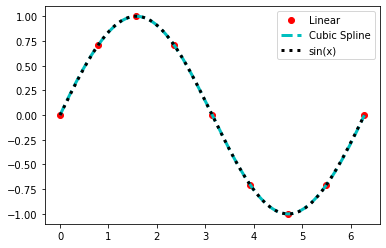

In [22]:
X = [np.pi*k/4 for k in range(9)]
Y = [np.sin(xk) for xk in X]
tck = splrep(X, Y, s=0)
xnew = np.linspace(X[0], X[-1], 1000)
ynew = splev(xnew, tck, der=0)
plt.plot(X, Y, 'ro', xnew, ynew, 'c--', xnew, np.sin(xnew), 'k:', lw=3)
plt.legend(['Linear', 'Cubic Spline', 'sin(x)'])

## InterpolatedUnivariateSpline
тоже работает на FITPACK.
## Пример 11. 
Построим сплайн для Примера 7 с помощью InterpolatedUnivariateSpline (объектно-ориентированная обертка для функций FITPACK).

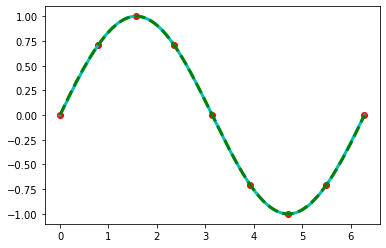

In [23]:
X = [np.pi*k/4 for k in range(9)]
Y = [np.sin(xk) for xk in X]
spl = InterpolatedUnivariateSpline(X, Y)
xs = np.linspace(X[0], X[-1], 1000)
plt.scatter(X, Y, color='red')
plt.plot(xs, np.sin(xs), 'c-', xs, spl(xs), 'g--', lw=3)

## Пример 12
Построим сплайн для Примера 7 с помощью CubicSpline

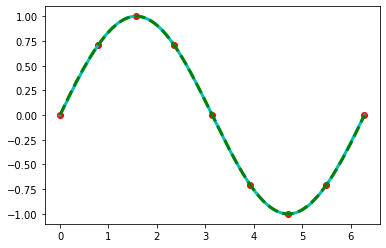

In [31]:
X = [np.pi*k/4 for k in range(9)]
Y = [np.sin(xk) for xk in X]
cs = CubicSpline(X, Y)
xs = np.linspace(X[0], X[-1], 1000)
plt.scatter(X, Y, color='red')
plt.plot(xs, np.sin(xs), 'c-', xs, cs(xs), 'g--', lw=3)

## Кривые Безье
#### Линейная кривая Безье
$P_0$ и $P_1$ две различные точки, тогда линейная кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = P_0 + t(P_1 - P_0) = (1 - t)P_0 + tP_1,\quad 1\le t \le 1 
$$
#### Квадратичная кривая Безье
$P_0$, $P_1$ и $P_2$ три различные точки, тогда квадратичная кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = (1 - t)^2P_0 + 2(1 - t)tP_1 + t^2P_2 = P_1 + (1 - t)^2(P_0 - P_1) + t^2(P_2 - P_1),\quad 1\le t \le 1 
$$
#### Кубическая кривая Безье
$P_0$, $P_1$, $P_2$ и $P_3$ четыре различные точки, тогда кубическая кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = (1 - t)^3P_0 + 3(1 - t)^2tP_1 + 3(1 - t)t^2P_2 +t^3P_3,\quad 1\le t \le 1 
$$
#### Общий вид кривой Безье
$P_0$, $P_1$, ...  и $P_n$ - $n$ различных точек, тогда линейная кривая Безье - отрезок, соединяющий эти точки:
$$
B(t) = \sum_{k=0}^n C_n^k(1 - t)^{n - k}t^kP_k,\quad 1\le t \le 1 
$$

https://bezier.readthedocs.io/en/stable/python/reference/bezier.curve.html

## Пример 13
Построим кривую Безье по точкам $P_1(-1, 3)$, $P_2(0, 4)$, $P_3(3, 2)$.

Для каждой точки построим полином Бернштейна $C_n^k(1 - t)^{n - k}t^k$, $1\le t \le 1$ и составим сумму произведений соответствующих координат точки на полиномы  Бернштейна.

In [24]:
from scipy.special import comb
def my_B(X, Y):
    n = len(X)
    def my_B_x(t):
        return sum([X[k]*comb(n - 1, k)*(1 - t)**(n - k - 1)*t**k for k in range(n)])
    def my_B_y(t):
        return sum([Y[k]*comb(n - 1, k)*(1 - t)**(n - k - 1)*t**k for k in range(n)])
    return (my_B_x, my_B_y)      

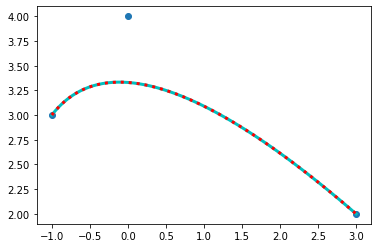

In [26]:
P1 = (-1, 3)
P2 = (0, 4)
P3 = (3, 2)
X = []
Y = []
for point in (P1, P2, P3):
    X.append(point[0])
    Y.append(point[1])
B_x, B_y = my_B(X, Y)
X1 = np.array(X).reshape(3, 1)
Y1 = np.array(Y).reshape(3, 1)
x = [0, 1]
bpX = BPoly(X1, x)
bpY = BPoly(Y1, x)
t_linspace = np.linspace(0, 1)
plt.plot(bpX(t_linspace), bpY(t_linspace), 'c-', B_x(t_linspace), B_y(t_linspace), 'r:', lw=3)
plt.scatter(X, Y)

## Пример 14
Построим кривую Безье с помощью модуля bezier:

https://bezier.readthedocs.io/en/stable/python/reference/bezier.curve.html

In [1]:
import bezier

NotImplementedError: cannot instantiate 'PackagePath' on your system

In [ ]:
nodes = np.asfortranarray([
...     [0.0, 0.625, 1.0],
...     [0.0, 0.5  , 0.5],
... ])
>>> curve = bezier.Curve(nodes, degree=2)
>>> curve